# Fine-tuning of pre-created model YAMNet

### Libraries used

In [20]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import librosa
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import Dense, Input, Embedding, Dropout, Concatenate, Flatten
from keras.models import Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback
from sklearn.model_selection import train_test_split
from collections import Counter


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
wandb.login()

True

In [100]:
exper = wandb.init(project="car_fault_detection",
                   name="yamnet_v3_balanced_classes",
                   config={
                        "epochs": 32,
                        "batch_size": 16,
                        "model": "YAMNet+MLP",
                        "context_embedding_dim": 4,
                        "dense_units": [256, 128]
    }
)

config = wandb.config

wandb_callback = [WandbMetricsLogger(), WandbModelCheckpoint(filepath='model.keras', monitor='val_loss', save_best_only=True)]

### Data load

In [6]:
DATA_PATH = "/content/drive/MyDrive/"

df = pd.read_csv(DATA_PATH + "metadata.csv")
df.head()

,file,label,context
0,bad_ignition_startup_state_0000.wav,bad_ignition,2
1,bad_ignition_startup_state_0001.wav,bad_ignition,2
2,bad_ignition_startup_state_0002.wav,bad_ignition,2
3,bad_ignition_startup_state_0003.wav,bad_ignition,2
4,bad_ignition_startup_state_0004.wav,bad_ignition,2


### Processing csv

In [7]:
df[df["context"].isna()]


,file,label,context


In [8]:
def extract_context_from_filename(filename):
    name = filename.lower()
    if "braking_state" in name:
        return 1
    elif "moving_state" in name:
        return 2
    elif "startup_state" in name:
        return 3
    elif "idle_state" in name:
        return 4
    else:
        return 0  # unknown


df["context"] = df["file"].apply(extract_context_from_filename)
df["context"].unique()

array([3, 2, 4, 1])

In [9]:
df[df["context"].isna()]

,file,label,context


In [10]:
df['label'].value_counts()

,count
label,
car_clean,300
car_knocking,299
normal_engine_idle,264
power_steering,129
serpentine_belt,116
low_oil,107
normal_brakes,77
worn_out_brakes,76
bad_ignition,62


### Model load

In [11]:
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")
print("YAMNet loaded")

YAMNet loaded


### Audio processing functions

In [19]:
def load_audio(path):
    y, sr = librosa.load(path, sr=16000)   # YAMNet expects 16kHz
    return y.astype(np.float32)


def get_embedding(path):
    waveform = load_audio(path)
    # YAMNet wants a tensor 1D float32
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    _, embeddings, _ = yamnet(waveform)
    embedding = tf.reduce_mean(embeddings, axis=0)  # (1024,)
    return embedding.numpy()

### Test to see if code works correctly

In [14]:
test_path = os.path.join(DATA_PATH, "audio", df.iloc[0]["file"])
emb = get_embedding(test_path)
emb.shape

(1024,)

### Generating embeddings for all audios

In [18]:
X_audio = []
X_context = []
y = []

for _, row in df.iterrows():
    filepath = os.path.join(DATA_PATH, "audio", row["file"])

    emb = get_embedding(filepath)  # 1024-d vector

    X_audio.append(emb)
    X_context.append(int(row["context"]))
    y.append(row["label"])

X_audio = np.array(X_audio)
X_context = np.array(X_context)
y = np.array(y)

print(X_audio.shape, X_context.shape, y.shape)


(1548, 1024) (1548,) (1548,)


### Data Augmentation

In [101]:


counter = Counter(y)
max_count = max(counter.values())

X_audio_new = []
X_context_new = []
y_new = []

for cls in counter:
    # get indices of this class
    idx = np.where(y == cls)[0]
    n_repeat = max_count // len(idx)
    n_extra = max_count % len(idx)

    # repeat full features
    X_audio_new.append(np.repeat(X_audio[idx], n_repeat, axis=0))
    X_context_new.append(np.repeat(X_context[idx], n_repeat, axis=0))
    y_new.append(np.repeat(y[idx], n_repeat, axis=0))

    # add remaining to reach max_count
    if n_extra > 0:
        extra_idx = np.random.choice(idx, size=n_extra, replace=False)
        X_audio_new.append(X_audio[extra_idx])
        X_context_new.append(X_context[extra_idx])
        y_new.append(y[extra_idx])


X_audio_bal = np.vstack(X_audio_new)
X_context_bal = np.concatenate(X_context_new)
y_bal = np.concatenate(y_new)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Label Encoding

In [102]:
le = LabelEncoder()
y_int = le.fit_transform(y_bal)
y_cat = to_categorical(y_int)

y_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

We have 11 different types of car problems.

### Train-test Split

In [103]:
X_audio_train, X_audio_test, X_context_train, X_context_test, y_train, y_test = train_test_split(
    X_audio_bal,
    X_context_bal,
    y_cat,        # one-hot labels
    test_size=0.2,
    stratify=y_int,   # MUY IMPORTANTE
    random_state=42
)


In [86]:
y_test_int = np.argmax(y_test, axis=1)

y_test_int


array([ 8,  6,  3,  8,  0,  0,  6,  0,  8,  0,  4,  2,  7,  1,  5,  4,  3,
        8,  7,  2,  4,  0,  3,  6,  4,  9,  8,  5,  5,  2,  6,  3,  3, 10,
        6,  1,  4,  0,  7,  4,  5,  4,  2,  5,  8,  8,  3, 10,  1,  4,  2,
        4,  3,  1,  7,  8,  5,  6,  0,  3,  2,  8,  8,  0, 10,  1,  9,  4,
       10, 10,  0,  3,  8, 10,  8,  1,  5,  7,  3,  0,  8,  8,  0,  2,  1,
        1,  1,  5, 10,  0,  3, 10,  6,  9,  8,  7,  7, 10,  4, 10, 10, 10,
        3,  2,  8,  5, 10,  5,  0,  6,  4,  9,  0,  9,  3,  9,  4,  8, 10,
        9,  2,  7,  1,  9,  1, 10,  4,  2,  7, 10,  1,  2,  6,  3,  2,  6,
        2,  8,  2,  6, 10,  4,  3,  1,  8,  5,  0,  8,  2,  9,  3,  7,  9,
       10,  4,  3,  5,  7,  9,  7,  7,  0,  2,  4,  5,  2,  1,  3,  8,  3,
        4,  1,  0,  5,  2,  3, 10,  2,  1,  2, 10,  7,  6,  3,  3,  0,  1,
       10,  6,  0, 10,  1,  8,  9,  4, 10,  6,  4,  6,  9,  5,  1,  9,  6,
        0,  3,  4,  0,  4,  3,  0, 10,  2,  6,  5,  1,  5,  2,  9,  2,  6,
        4, 10, 10,  0, 10

### Model construction

In [104]:
# Inputs
inp_audio = Input(shape=(1024,), name="audio_embedding")
inp_context = Input(shape=(1,), dtype="int32", name="context_id")

# Context embedding
ctx_emb = Embedding(input_dim=5, output_dim=4, name="context_embedding")(inp_context)
ctx_emb = Flatten()(ctx_emb)

# Combine audio + context
x = Concatenate()([inp_audio, ctx_emb])

# Dense layers
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)

# Output layer
out = Dense(len(le.classes_), activation="softmax", name="output")(x)

# Build model
model = Model(inputs=[inp_audio, inp_context], outputs=out)

# Compile
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_embedding   │ (None, 1, 4)      │         20 │ context_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_embedding     │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4)         │          0 │ context_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1028)      │          0 │ audio_embedding[… │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    131,712 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 11)        │        715 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,703 (549.62 KB)

 Trainable params: 140,703 (549.62 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [105]:
history = model.fit(
    [X_audio_train, X_context_train],
    y_train,
    validation_split=0.2,
    batch_size=config.batch_size,
    callbacks=wandb_callback,
    epochs=config.epochs
)


Epoch 1/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3086 - loss: 2.0737 - val_accuracy: 0.6515 - val_loss: 1.1161
Epoch 2/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7006 - loss: 0.9968 - val_accuracy: 0.7860 - val_loss: 0.5942
Epoch 3/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8060 - loss: 0.6377 - val_accuracy: 0.8409 - val_loss: 0.4654
Epoch 4/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8429 - loss: 0.4781 - val_accuracy: 0.8390 - val_loss: 0.4063
Epoch 5/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8715 - loss: 0.3785 - val_accuracy: 0.8674 - val_loss: 0.3605
Epoch 6/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8762 - loss: 0.3593 - val_accuracy: 0.8750 - val_loss: 0.3325
Epoch 7/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8914 - loss: 0.2938 - val_accuracy: 0.8977 - val_loss: 0.3042
Epoch 8/32
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8869 - loss: 0.3000 - val_accu

In [106]:
exper.finish()

epoch/accuracy,▁▅▆▆▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▅▆▆▇▆▇▇▇█▇▇█▇████████████████
epoch/val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch/accuracy,0.96828
epoch/epoch,31
epoch/learning_rate,0.001
epoch/loss,0.08488
epoch/val_accuracy,0.9375


### Testing model

In [107]:
y_pred_probs = model.predict([X_audio_test, X_context_test])
y_pred_int = np.argmax(y_pred_probs, axis=1)

df_compare = pd.DataFrame({
    "true_label": [le.classes_[i] for i in y_test_int],
    "pred_label": [le.classes_[i] for i in y_pred_int],
    "correct": (y_test_int == y_pred_int),
    "pred_confidence": np.max(y_pred_probs, axis=1)
})

df_compare


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


,true_label,pred_label,correct,pred_confidence
0,power_steering,power_steering,True,0.936290
1,normal_engine_idle,normal_engine_idle,True,0.999707
2,dead_battery,dead_battery,True,0.999646
3,power_steering,power_steering,True,0.999347
4,bad_ignition,bad_ignition,True,1.000000
...,...,...,...,...
655,bad_ignition,bad_ignition,True,0.999974
656,serpentine_belt,normal_engine_idle,False,0.559202
657,normal_brakes,normal_brakes,True,0.999964
658,worn_out_brakes,worn_out_brakes,True,1.000000


In [108]:
test_loss, test_acc = model.evaluate(
    [X_audio_test, X_context_test],
    y_test,
    verbose=1
)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9547 - loss: 0.1855
Test Accuracy: 0.9484848380088806
Test Loss: 0.2142251878976822


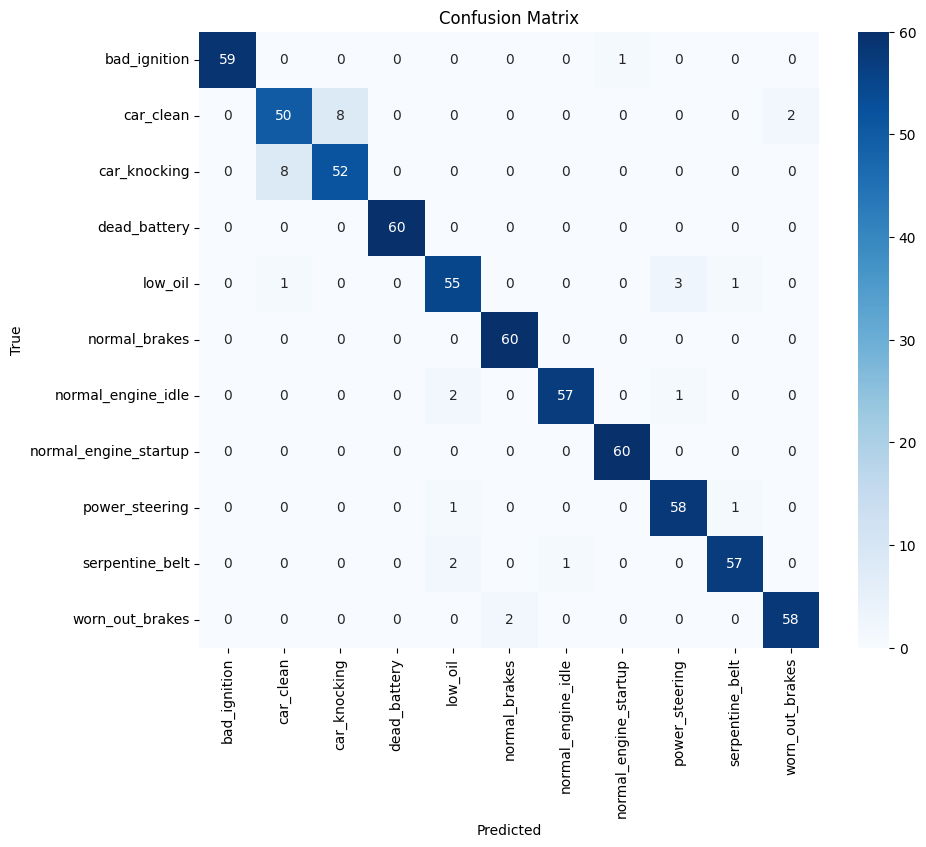

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_int, y_pred_int)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [110]:
from sklearn.metrics import classification_report

print(classification_report(y_test_int, y_pred_int, target_names=le.classes_))


                       precision    recall  f1-score   support

         bad_ignition       1.00      0.98      0.99        60
            car_clean       0.85      0.83      0.84        60
         car_knocking       0.87      0.87      0.87        60
         dead_battery       1.00      1.00      1.00        60
              low_oil       0.92      0.92      0.92        60
        normal_brakes       0.97      1.00      0.98        60
   normal_engine_idle       0.98      0.95      0.97        60
normal_engine_startup       0.98      1.00      0.99        60
       power_steering       0.94      0.97      0.95        60
      serpentine_belt       0.97      0.95      0.96        60
      worn_out_brakes       0.97      0.97      0.97        60

             accuracy                           0.95       660
            macro avg       0.95      0.95      0.95       660
         weighted avg       0.95      0.95      0.95       660



### Example of what the user would receive

In [113]:
def predict_top3_from_test(i):
    # Embedding shape must be (1, 1024)
    emb = np.array(X_audio_test[i]).reshape(1, 1024)

    # Context must be shape (1,1)
    ctx_val = int(X_context_test[i])            # asegurar que es entero
    ctx = np.array([[ctx_val]], dtype=np.int32) # shape correcta

    # Predict
    probs = model.predict([emb, ctx], verbose=0)[0]

    # Top 3 indices
    top3_idx = probs.argsort()[-3:][::-1]

    return [(le.classes_[j], float(probs[j])) for j in top3_idx]


predict_top3_from_test(150)


[(np.str_('dead_battery'), 0.9999990463256836),
 (np.str_('normal_engine_startup'), 7.576037432954763e-07),
 (np.str_('worn_out_brakes'), 2.7338160180079285e-07)]